## Analyzing A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

[A/B tests](https://en.wikipedia.org/wiki/A/B_testing) are very commonly performed by e-commerce platforms to monitor user conversion, click through rate and other insightfull metrics.

Using Python and its libraries, my goal here was to set and run the Hypothesis Testing to check if there was statistical significance backing up the Alternative Hypothesis: the new webpage has a higher conversion rate than the old page. 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [84]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [85]:
df = pd.read_csv('./ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [86]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [87]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [88]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [89]:
df.query('(group == "treatment" and landing_page != "new_page")\
or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [90]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page, so I dropped them.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store the new dataframe in **df2**.

In [91]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page")\
or (group != "treatment" and landing_page == "new_page")\
or (group == "control" and landing_page != "old_page")\
or (group != "control" and landing_page == "old_page")').index)

In [92]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Checking the new data frame figures

a. How many unique **user_id**s are in **df2**?

In [93]:
df2['user_id'].nunique()

290584

b. Is there any **user_id** repeated in **df2**?

In [94]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove **one** of the rows with a duplicate **user_id**.

In [96]:
df2 = df2.drop(df2[(df2.user_id == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Some questions around probability

a. What is the probability of an individual converting regardless of the page they receive?

In [97]:
all_converted_users = float(df2.query('converted == 1')['user_id'].nunique())
converted_rate = all_converted_users/float(df2.shape[0])
print("The probability of an individual converting regardless of the page they receive is {0:.2%}.".format(converted_rate))

The probability of an individual converting regardless of the page they receive is 11.96%.


b. Given that an individual was in the `control` group, what is the probability they converted?

In [98]:
control_converted_users = float(df2.query('group == "control" and converted == 1')['user_id'].nunique())
control_size = float(df2.query('group == "control"')['user_id'].nunique())
cr_control = control_converted_users/control_size
print("The probability of an individual converting, given an individual \
received the control page, is {0:.2%}.".format(cr_control))

The probability of an individual converting, given an individual received the control page, is 12.04%.


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [99]:
treat_converted_users = float(df2.query('group == "treatment" and converted == 1')['user_id'].nunique())
treat_size = float(df2.query('group == "treatment"')['user_id'].nunique())
cr_treat = treat_converted_users/treat_size
print("The probability of an individual converting, given an individual received \
the treatment page, is {0:.2%}.".format(cr_treat))


The probability of an individual converting, given an individual received the treatment page, is 11.88%.


d. What is the probability that an individual received the new page?

In [100]:
received_treat = float(df2.query('group == "treatment"')['user_id'].nunique())
p4 = received_treat/float(df2.shape[0])
print("The probability that an individual received the new page is {0:.2%}.".format(p4))

The probability that an individual received the new page is 50.01%.


e. Conclusions of Part I:

The probability of an individual converting regardless of the page they receive is 11.96%

The probability of an individual converting, given an individual received the control page, is 12.04%.

The probability of an individual converting, given an individual received the treatment page, is 11.88%.

As the 3 results above are pretty closer to each other, there is no suggestion that the treatment has led to a higher conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Setting the Null $(H_{0})$ and Alternative $(H_{1})$ Hypothesis:

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assuming that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. 
Also assuming that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

The sample size for each page was equal to the ones in **ab_data.csv**.  <br><br>

The sampling distribution was performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [101]:
p_new = round(float(df2.query('converted == 1')['user_id'].nunique())/float(df2['user_id'].nunique()),4)
p_new

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [102]:
p_old = round(float(df2.query('converted == 1')['user_id'].nunique())/float(df2['user_id'].nunique()),4)
p_old

0.1196

c. What is $n_{new}$?

In [103]:
# Calculating the number of users on treatment
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [104]:
# Calculating the number of users on control
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [105]:
new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [106]:
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [107]:
# Calculating the probablity of new page conversion rate
new_page_converted.mean()

0.8800701947560388

In [108]:
# Calculating the probablity of old page conversion rate
old_page_converted.mean()

0.8791731486707877

In [109]:
# Calculating the difference in probability of conversion rate
new_page_converted.mean() - old_page_converted.mean()

0.0008970460852510964

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [116]:
# Creating the sampling distribution of the conversion rate difference between treatment and control groups with bootstrap
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**. 

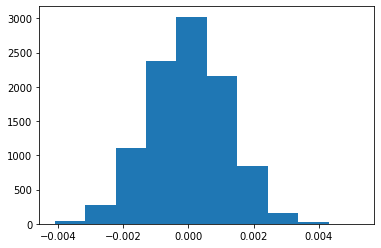

In [117]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [118]:
# Creating the number of converted users for treatment and control groups
conv_treat = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
conv_control = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

In [119]:
# Calculating the conversion rate
cv_rate_treat = float(conv_treat)/ float(n_new) 
cv_rate_control = float(conv_control)/ float(n_old)

In [120]:
# Calculating the observed difference in converted rate 
obs_diff = cv_rate_treat - cv_rate_control
obs_diff

-0.0015782389853555567

In [121]:
# Creating the normal distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

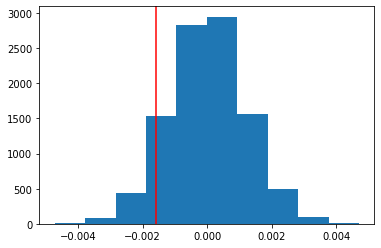

In [122]:
# Plotting the Null distribution with the line representing where the observed statistic falls
plt.hist(null_vals)
plt.axvline(x=obs_diff, color ='red')

In [125]:
# Calculating the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv
(null_vals > obs_diff).mean()

0.9111

k. What conclusion we can take from this p-value?

By comparing the p-value to the type I error (α, which means finding Hypothesis 1 is true when in fact it is false), we can decide whether to reject or fail to reject the Null hypothesis (Hypothesis 0).

With a p-value higher than 0.05, the difference in conversion rate for the control and treatment groups does not appear to be significant. In other words, it seems likely that our statistic is from the null hypothesis (failing to reject the null hypothesis).

l. Using z-test built-in solution to verify the results.

In [42]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

m. Using `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [41]:
# Finding the test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), \
                                              alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [43]:
# Calculating the critical value at 95% confidence to consider the alternative hypothesis
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is the distance from the treatment mean to the control mean in units of the standard error.

On this case, we used a one tail (or one-sided) test, as we are checking if the proportion in conversion rates from the new page are bigger than the proportion in conversion rates from the old page.

The p-value of 0.905 is larger than 0.05 and so we also fail to reject the null hypothesis using the p-value.

Since the z-value of -1.31 does not exceed the critical value at 95% confidence (1.96), we failed to reject the null hypothesis. In other words, the difference in conversion rate for the control and treatment groups does not appear to be significant.

Those results are aligned with the findings in parts j. and k.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will check if the result acheived in the previous A/B test can also be acheived by performing a Logistic Regression.

a. Used **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. 

Created dummy variables for landing_page types.

Added **intercept** column, and an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [110]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [111]:
# Creating a column for the intercept
df2['intercept'] = 1

In [112]:
# Creating a dummy variable 'ab_page' column for which page each user received, 1=treatment
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


b. Using **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [113]:
# Creating the logistic regression model (lm)
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [114]:
# Fitting the result of the model
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Providing the summary of the model below;

In [115]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:31:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Conclusions:

The p-value associated with ab_page is 0.190.

The results are different because we have two different Null Hypothesis.

On Part II, the Null hypothesis assumes that the new page has equal or worse conversion than the old page. The Alternative hypothesis assumes that the new page has better conversion than the old page.

On Part III, the Null hypothesis is zero (meaning that the user was not converted), the Alternative hypothesis in Logistic Regression is one (meaning the user was converted).

f. Considering the advantages and disavantages of adding other explanatory variables on the model

The advantage of considering other explanatory variables is that they can be analyzed to see if they influence the conversion result or not. For example, if we classify the timestamp and create other dummy variables like weekday, weekend, AM, PM, morning, afternoon or night they could identify if type of day and time of the day were statistically significant on influencing the conversion.

The down points of using other variables is that we could increase the multicollinearity (explanatory variables related one to another). Also we could increase the Non-linearity of the response-predictor relationships, the number of Outliers, the Non-constant Variance and Normally Distributed Errors and the Correlation of error terms.

g. Joining the tables and running the new Logistic Regression Model

In [144]:
countries_df = pd.read_csv('./countries.csv')
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [145]:
### Creating the necessary dummy variables and dropping 'CA' country column
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,new_page,old_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [146]:
# Creating intercept variable
df3['intercept'] = 1

In [147]:
# Creating the logistic regression using CA and old page as baseline
lm_3 = sm.Logit(df3['converted'], df3[['intercept','new_page','UK','US']])
result = lm_3.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


h. Providing the summary results and conclusions

In [148]:
### Providing the summary results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        10:13:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [160]:
# New_page result interpretation - divided by one to get the reciprocal
1/np.exp(-0.0149)

1.0150115583846535

In [161]:
# UK and US result interpretation
np.exp(0.0506),np.exp(0.0408)

(1.0519020483004984, 1.0416437559600236)

For every unit decrease in new_page, conversion will be 1.01 times more likely to happen, holding all other varible constant.

For every unit increase in UK, conversion is 1.05 times more likely to happen, holding all other variable constant.

For every unit increase in US, conversion is 1.04 times more likely to happen, holding all other variable constant.

The p-values for all the coefficients are above 0.05, suggesting that the difference in conversion rate was not significantly neither using a new page, or using a new page on different countries.

<a id='conclusions'></a>
## Conclusions

This notebook's purpose was to analyze the A/B Test results using Hypothesis Testing and Logistic Regression.

After wrangling and cleaning the dataset on Part I, we performed a Hypothesis Testing on the data, which resulted on failing to reject the Null Hypothesis. In other terms, there was no statistical significance to affirm that the new page contributed to more conversion.

On Part II, we did a Logistic Regression to check again if the Alternative Hypothesis' probability was statistically significant, again, this result was pretty similar to what we found on Part I. 

We also failed to reject the Null Hypothesis adding a new explanatory variable, the users' country.

In resume, on all tests performed with the data, there is no statistiall significance to support the Hypothesis that the new page has a better conversion rate than the old page. Therefore, we suggest to not launch the new page.